In [1]:
%matplotlib inline
import pickle
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
X,y_hr,y_participant,y_activity,y_time = pickle.load(open('../data/wisdm_individual_windows_20.p','rb'))

In [2]:
X.shape

(10476, 400, 3)

In [3]:
Fs = 20
window_size = 20
n_timesteps = window_size*Fs
X = X[:,:,:].reshape(-1,n_timesteps,3)
X = X/9.8
X[X<-2] = -2
X[X>2] = 2

In [4]:
X_magnitude = np.array([np.sqrt(np.sum(np.square(a),axis=1)) for a in X])

In [5]:
X = X_magnitude.reshape(-1,n_timesteps,1)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
# import numpy as np
# %matplotlib notebook
from tensorflow.keras.layers import Conv1D,BatchNormalization,Dropout,Input,MaxPooling1D,Flatten,Dense,Input
from tensorflow.keras.models import Model, Sequential

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPU


In [7]:
import tensorflow_addons as tfa
def get_model(input_shape=(200,1),act='tanh',loss="mae",opt='adam',n_classes=1):
    model =  Sequential()
    model.add(Conv1D(100,10,input_shape=input_shape,activation='linear',kernel_initializer='normal',padding='same'))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Conv1D(200,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(50,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(4))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(n_classes*20,activation='relu',kernel_initializer='normal'))
#     model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1),name='embedding'))
    model.add(Dense(n_classes,activation=None,kernel_initializer='normal'))
    model.add(Dense(n_classes,activation='softmax',kernel_initializer='normal'))
    model.compile(loss=loss,optimizer=opt)
    return model
from focal_loss import BinaryFocalLoss,SparseCategoricalFocalLoss
model =  get_model(input_shape=(n_timesteps,1),n_classes=len(np.unique(y_activity)),loss=SparseCategoricalFocalLoss(gamma=2))
model.summary()

/home/azim/miniconda3/envs/test1/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210310). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 400, 100)          1100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 100)          100100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 100)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 100)          400       
_________________________________________________________________
dropout (Dropout)            (None, 200, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 100)          100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 100)          0

In [8]:
from keras.models import load_model
n_classes = len(np.unique(y_activity))
model =  get_model(input_shape=(n_timesteps,1),n_classes=n_classes,loss=SparseCategoricalFocalLoss(gamma=1))
filepath = '../model_files/activity_estimator_wisdm_magnitude_final_5_labels.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callbacks_list = [es,checkpoint]
train_x,test_x,train_y,test_y = train_test_split(X,y_activity,test_size=.3,stratify=y_activity)
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size=.2,stratify=train_y)
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=300, batch_size=100,verbose=1,
      callbacks=callbacks_list,shuffle=True)

Epoch 1/300
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
59/59 [==============================] - 5s 32ms/step - loss: 0.9173 - val_loss: 2.7820

Epoch 00001: val_loss improved from inf to 2.78201, saving model to ../model_files/activity_estimator_wisdm_magnitude_final_5_labels.hdf5
Epoch 2/300
59/59 [==============================] - 1s 18ms/step - loss: 0.2467 - val_loss: 3.6613

Epoch 00002: val_loss did not improve from 2.78201
Epoch 3/300
59/59 [==============================] - 1s 19ms/step - loss: 0.1187 - val_loss: 0.4962

Epoch 00003: val_loss improved from 2.78201 to 0.49624, saving model to ../model_files/activity_estimator_wisdm_magnitude_final_5_labels.hdf5
Epoch 4/300
59/59 [==============================] - 1s 19ms/step - loss: 0.0983 - val_loss: 0.3104

Epoch 00004: val_loss improved from 0.49624 to 0.31044, saving model to ../model_files/activity_estimator_wisdm_magnitude_final

In [9]:
model.load_weights(filepath)
y_pred = model.predict(test_x).argmax(axis=1)

In [10]:
from sklearn.metrics import confusion_matrix

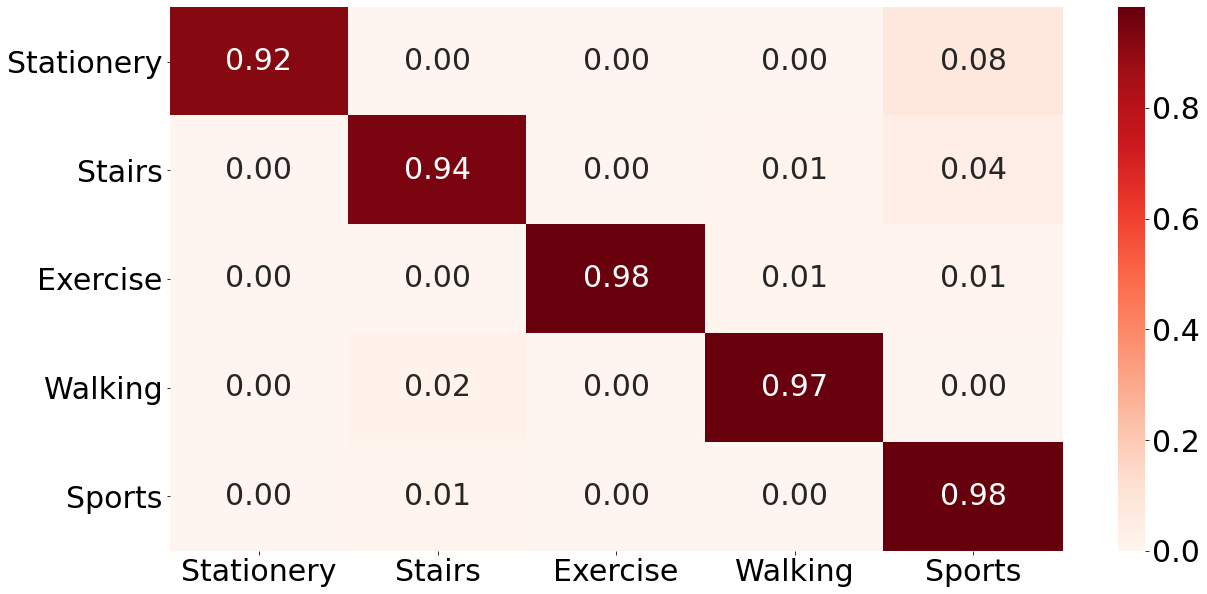

In [11]:

activity_list = ['Stationery','Stairs','Exercise','Walking','Sports']
import seaborn as sns
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(test_y,y_pred,normalize='true'),annot=True,cmap='Reds',fmt='.2f')
plt.xticks(np.arange(.5,len(activity_list)+.5,1),activity_list)
plt.yticks(np.arange(.5,len(activity_list)+.5,1),activity_list,rotation=0)
plt.show()

In [28]:
import seaborn as sns
activity_list = ['Sitting','Stairs','Jogging','Typing','Standing','Walking','Brushing','Eating','Drinking','Kicking',
                'Playing Catch','Dribbling','Writing','Clapping','Folding Clothes']
activity_dict = {0:'No Label',
                1:'Sitting',
                2:'Stairs',
                3:'Soccer',
                4:'Cycling',
                5:'Driving',
                6:'Lunch',
                7:'Walking',
                8:'Working'}
X,y_hr,y_participant,y_activity,y_time = pickle.load(open('../data/dalia_individual_windows_10.p','rb'))
X = X[:,:,1:]*64
model.load_weights(filepath)
from scipy.interpolate import interp1d

def interpolate_acl(a,window_size=10,fs_now=32,fs_new=20):
    x_now = np.linspace(0,window_size,window_size*fs_now)
    f = interp1d(x_now,a,axis=0,fill_value='extrapolate')
    x_new = np.linspace(0,window_size,window_size*fs_new)
    return f(x_new)

X_new = np.array([interpolate_acl(a) for a in X])
X_magnitude = np.array([np.sqrt(np.sum(np.square(a),axis=1)) for a in X_new]).reshape(-1,200,1)
y_pred = model.predict(X_magnitude).argmax(axis=1)

In [26]:
y_pred_labels = [activity_list[a] for a in y_pred]

In [29]:
y_orig_labels = [activity_dict[a] for a in y_activity]

In [31]:
import pandas as pd

In [35]:
df = pd.DataFrame({'Dalia':y_orig_labels,'WISDM':y_pred_labels})

In [36]:
df['value'] = 1

In [51]:
data = pd.pivot_table(df,index='Dalia',columns='WISDM',values='value',aggfunc='sum')

In [52]:
data = data.fillna(0)

In [53]:
for a in activity_dict.values():
    data.loc[a] = data.loc[a]/data.loc[a].sum()

In [56]:
y = data.index.values

In [62]:
x = data.columns.values

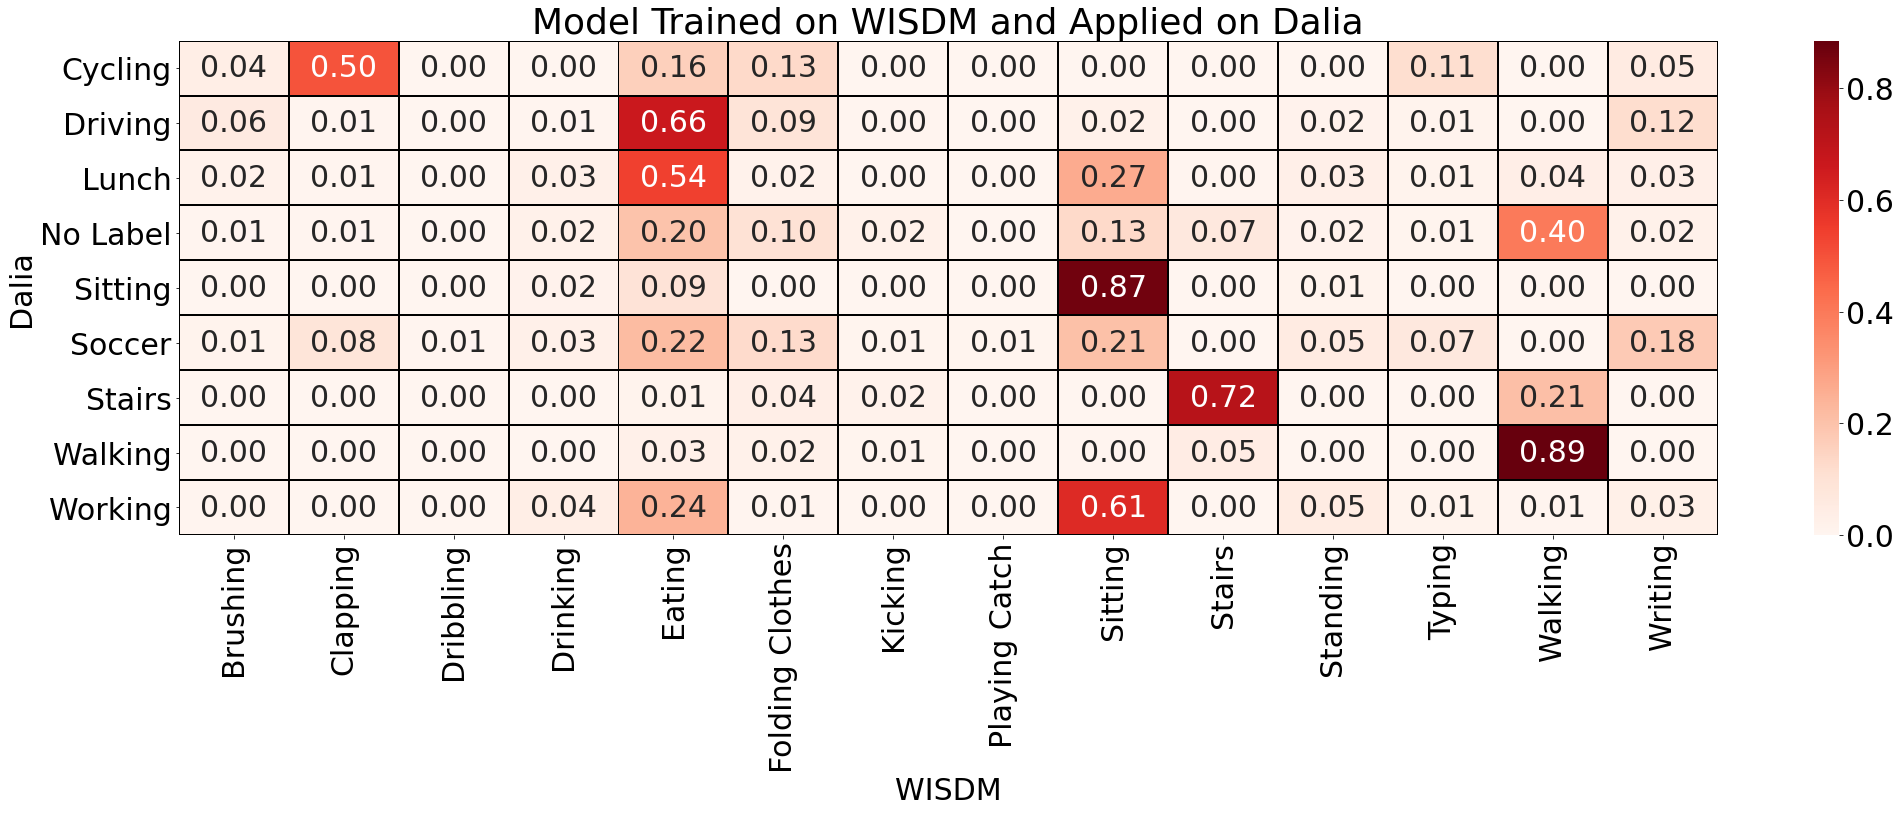

In [74]:
import seaborn as sns
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(30,12))
sns.heatmap(data,annot=True,fmt='.2f',cmap='Reds',linecolor='black',linewidths=1)
plt.title('Model Trained on WISDM and Applied on Dalia')
plt.tight_layout()
plt.savefig('confusion_matrix_train_on_wisdm_test_on_dalia.png')
plt.show()

In [59]:
data.columns

Index(['Brushing', 'Clapping', 'Dribbling', 'Drinking', 'Eating',
       'Folding Clothes', 'Kicking', 'Playing Catch', 'Sitting', 'Stairs',
       'Standing', 'Typing', 'Walking', 'Writing'],
      dtype='object', name='WISDM')

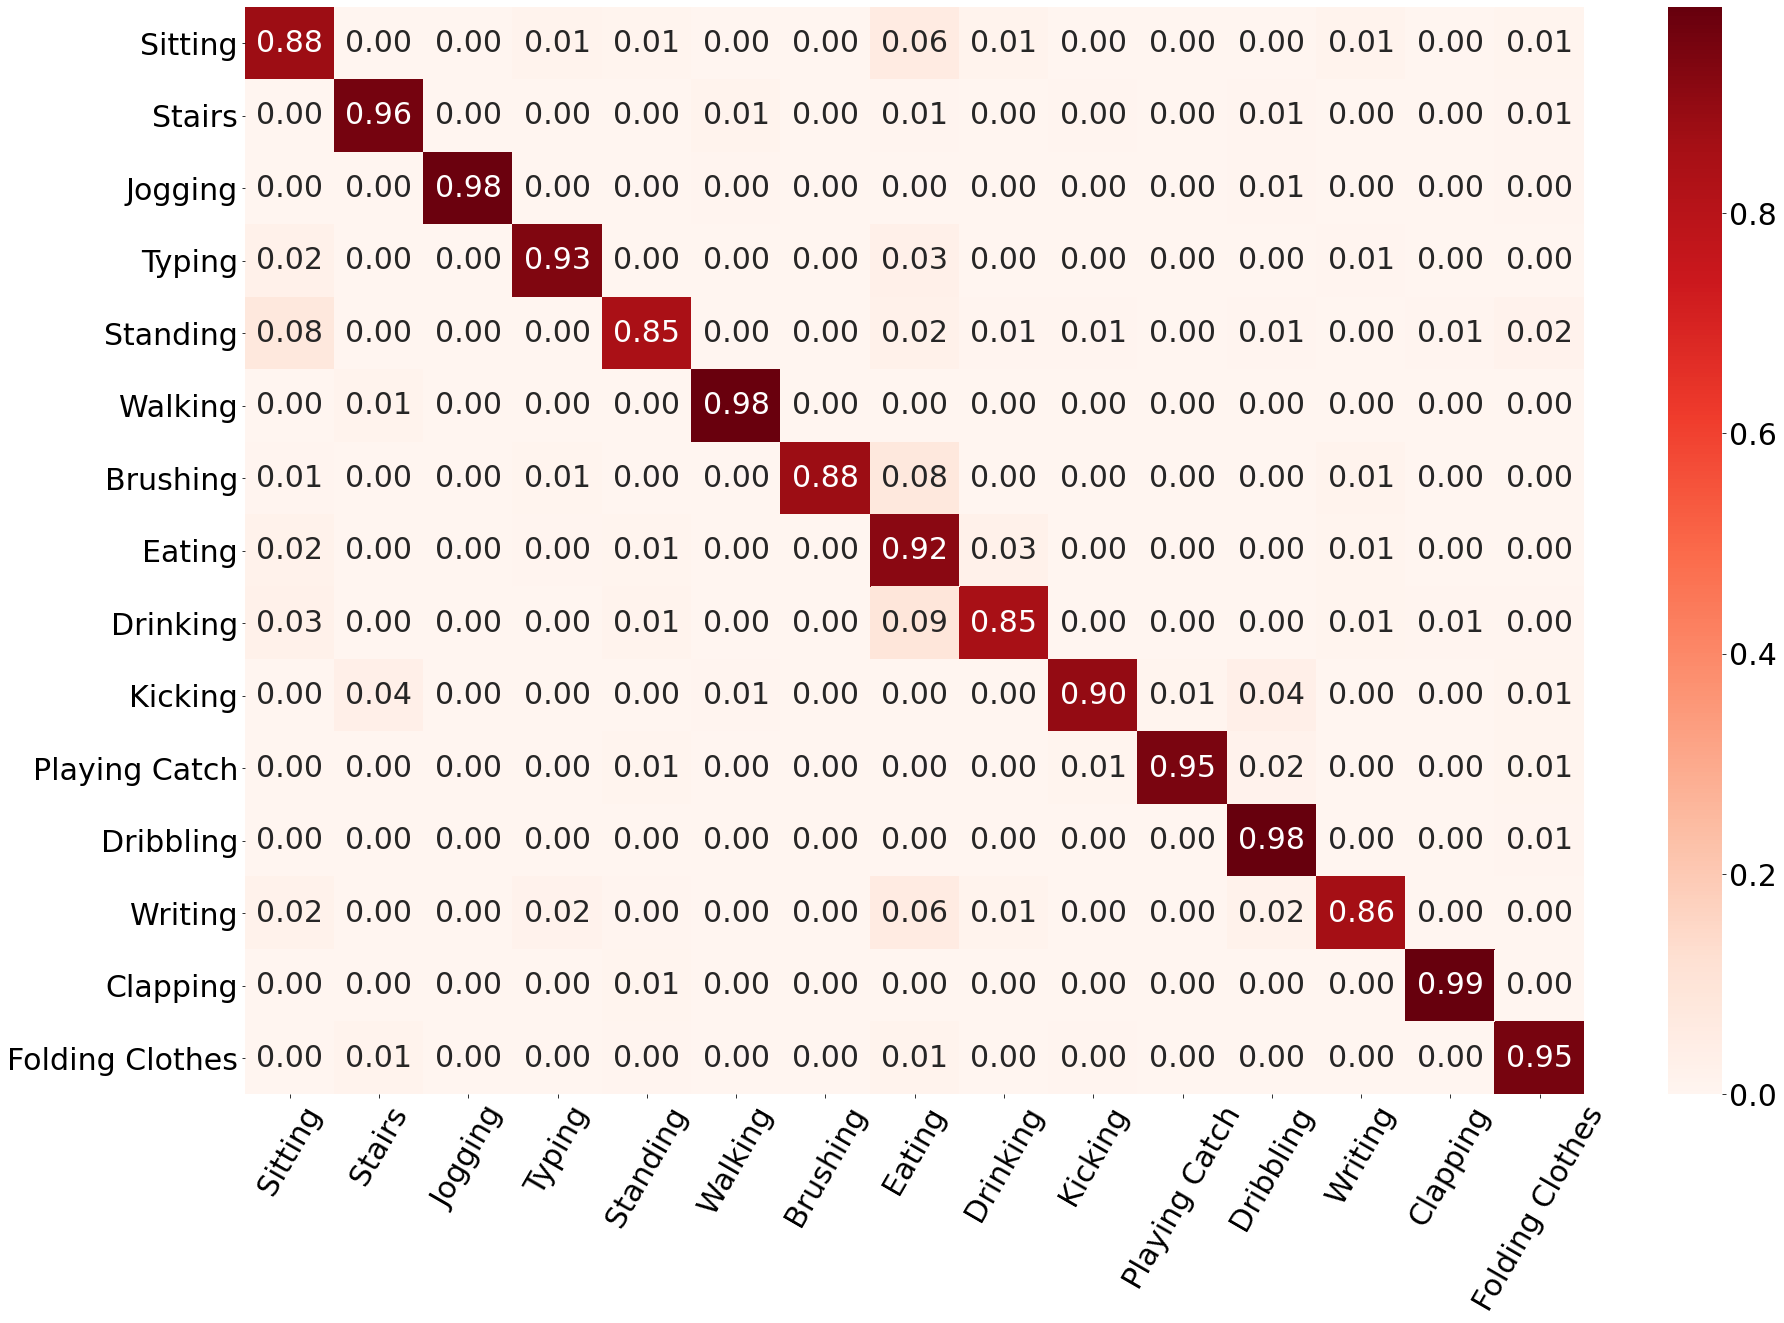

In [86]:
import seaborn as sns
activity_list = ['Sitting','Stairs','Jogging','Typing','Standing','Walking','Brushing','Eating','Drinking','Kicking',
                'Playing Catch','Dribbling','Writing','Clapping','Folding Clothes']
model.load_weights(filepath)
test_y_pred = model.predict(test_x).argmax(axis=1)
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(30,20))
sns.heatmap(confusion_matrix(test_y,test_y_pred,normalize='true'),annot=True,fmt='.2f',cmap='Reds')
plt.xticks(np.array(range(15))+.5,activity_list,rotation=60)
plt.yticks(np.array(range(15))+.5,activity_list,rotation=0)
plt.savefig('confusion_matrix_orientation.png')
plt.show()

In [23]:
model.load_weights(filepath)
X,y_hr,y_participant,y_activity,y_time = pickle.load(open('../data/dalia_individual_windows_10.p','rb'))
X = X[:,:,1:]*64

activity_dict = {0:'No Label',
                1:'Sitting',
                2:'Stairs',
                3:'Soccer',
                4:'Cycling',
                5:'Driving',
                6:'Lunch',
                7:'Walking',
                8:'Working'}

activity_dict1 = {'No Label':-1,
                'Sitting':0,
                'Stairs':1,
                'Soccer':2,
                'Cycling':3,
                'Driving':4,
                'Lunch':-1,
                'Walking':5,
                'Working':-1}

y_activity = np.array([activity_dict1[activity_dict[a]] for a in y_activity])

from scipy.interpolate import interp1d

def interpolate_acl(a,window_size=10,fs_now=32,fs_new=20):
    x_now = np.linspace(0,window_size,window_size*fs_now)
    f = interp1d(x_now,a,axis=0,fill_value='extrapolate')
    x_new = np.linspace(0,window_size,window_size*fs_new)
    return f(x_new)

X_new = np.array([interpolate_acl(a) for a in X])

y_activity_new = y_activity[np.where((y_activity==0)|(y_activity==1)|(y_activity==5))[0]]
X_new = X_new[np.where((y_activity==0)|(y_activity==1)|(y_activity==5))[0]]

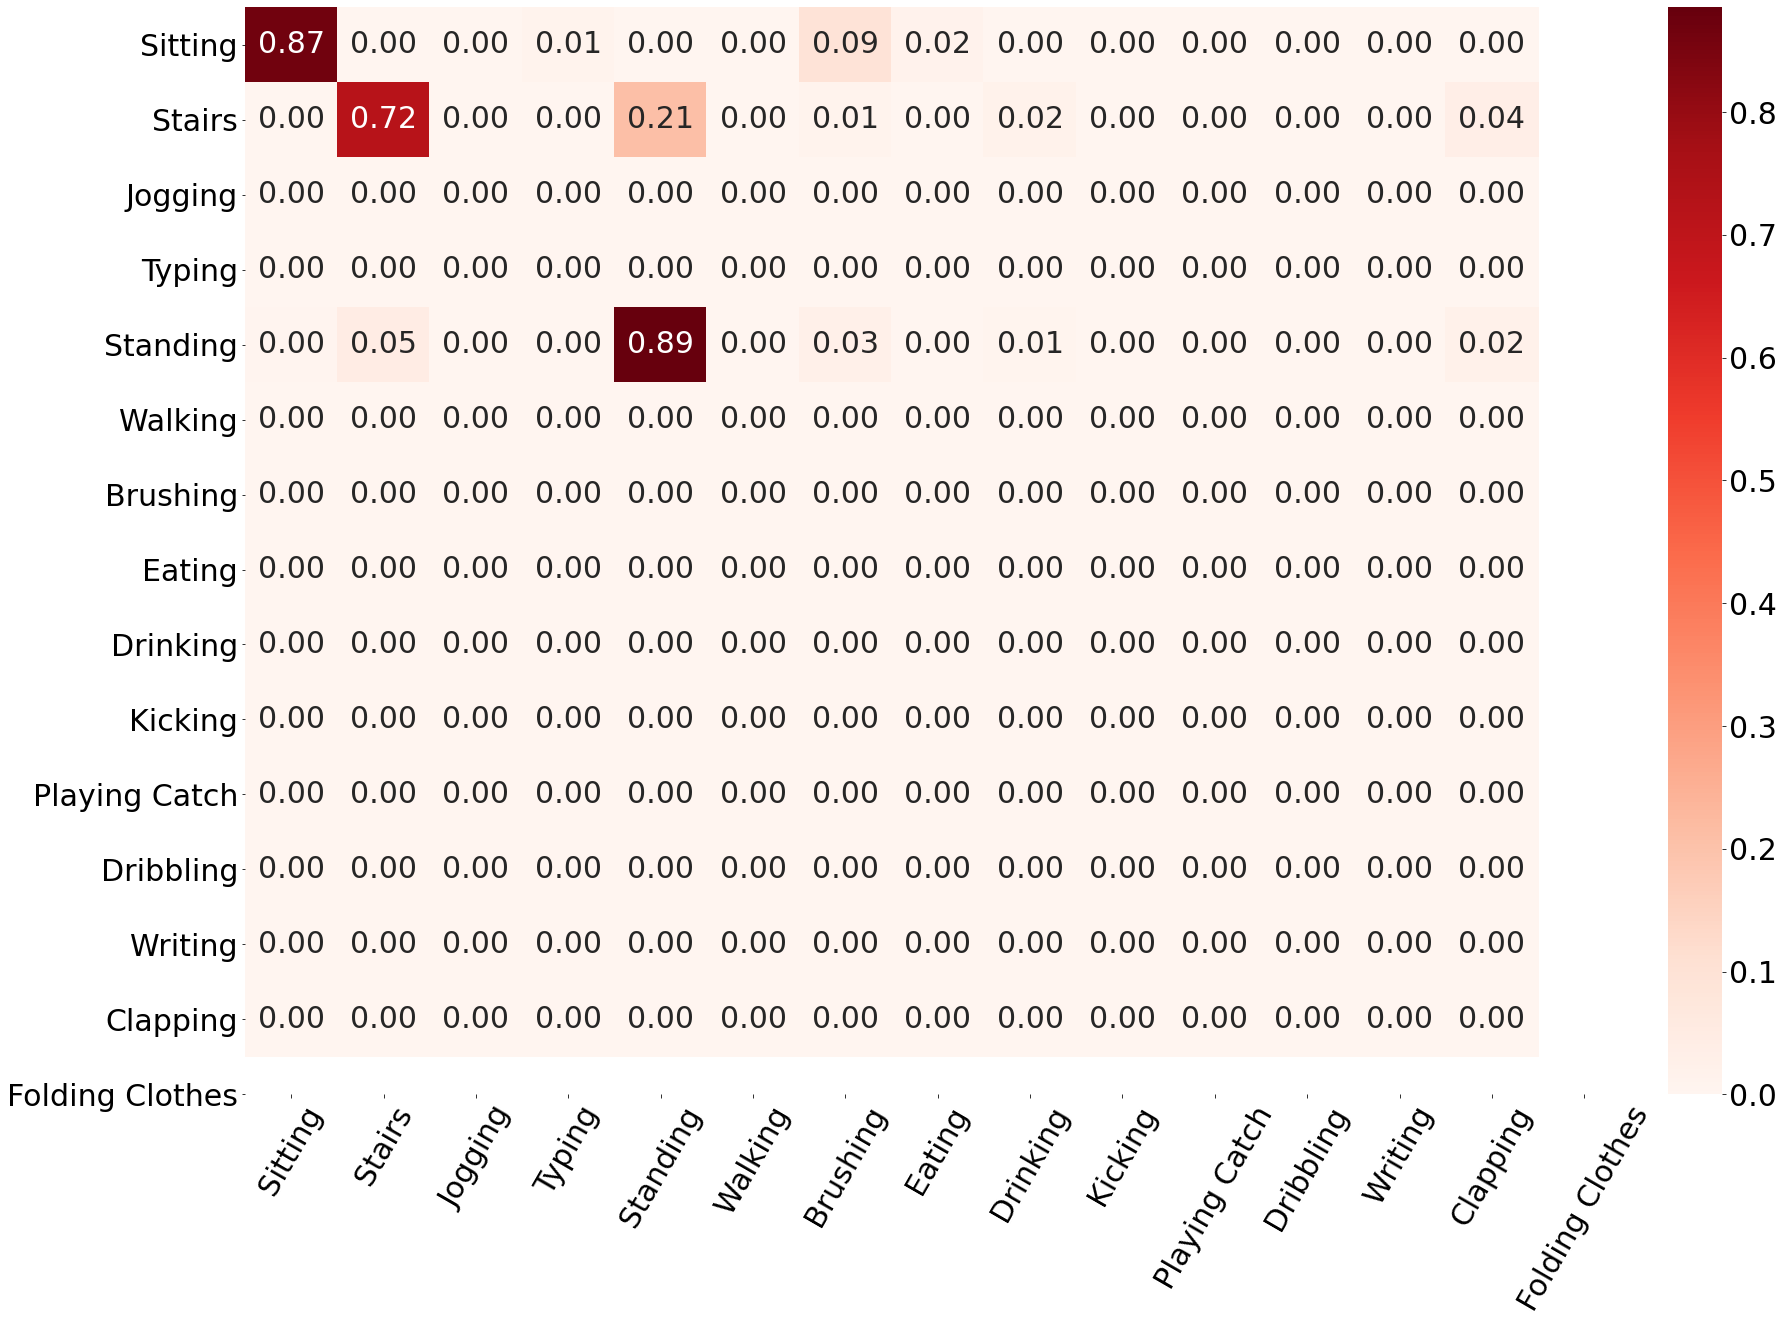

In [24]:
from sklearn.metrics import confusion_matrix
X_magnitude = np.array([np.sqrt(np.sum(np.square(a),axis=1)) for a in X_new]).reshape(-1,200,1)
y_pred = model.predict(X_magnitude).argmax(axis=1)

plt.rcParams.update({'font.size':30})
plt.figure(figsize=(30,20))
sns.heatmap(confusion_matrix(y_activity_new,y_pred,normalize='true'),annot=True,fmt='.2f',cmap='Reds')
plt.xticks(np.array(range(15))+.5,activity_list,rotation=60)
plt.yticks(np.array(range(15))+.5,activity_list,rotation=0)
plt.savefig('confusion_matrix_magnitude_wisdm_to_dalia.png')
plt.show()

In [74]:
X,y_hr,y_participant,y_activity,y_time = pickle.load(open('../data/dalia_individual_windows_10.p','rb'))
X = X[:,:,1:]*64

activity_dict = {0:'No Label',
                1:'Sitting',
                2:'Stairs',
                3:'Soccer',
                4:'Cycling',
                5:'Driving',
                6:'Lunch',
                7:'Walking',
                8:'Working'}

activity_dict1 = {'No Label':-1,
                'Sitting':0,
                'Stairs':1,
                'Soccer':2,
                'Cycling':3,
                'Driving':4,
                'Lunch':-1,
                'Walking':5,
                'Working':-1}

y_activity = np.array([activity_dict1[activity_dict[a]] for a in y_activity])

from scipy.interpolate import interp1d

def interpolate_acl(a,window_size=10,fs_now=32,fs_new=20):
    x_now = np.linspace(0,window_size,window_size*fs_now)
    f = interp1d(x_now,a,axis=0,fill_value='extrapolate')
    x_new = np.linspace(0,window_size,window_size*fs_new)
    return f(x_new)

X_new = np.array([interpolate_acl(a) for a in X])

y_activity_new = y_activity[np.where((y_activity==0)|(y_activity==1)|(y_activity==5))[0]]
X_new = X_new[np.where((y_activity==0)|(y_activity==1)|(y_activity==5))[0]]

X_magnitude = np.array([np.sqrt(np.sum(np.square(a),axis=1)) for a in X_new]).reshape(-1,200,1)

y_pred = model.predict(X_magnitude).argmax(axis=1)

plt.rcParams.update({'font.size':30})
plt.figure(figsize=(30,20))
sns.heatmap(confusion_matrix(y_activity_new,y_pred,normalize='true'),annot=True,fmt='.2f',cmap='Reds')
plt.xticks(np.array(range(15))+.5,activity_list,rotation=60)
plt.yticks(np.array(range(15))+.5,activity_list,rotation=0)
plt.savefig('confusion_matrix_magnitude.png')
plt.show()

In [ ]:
from keras.models import load_model
logo = LeaveOneGroupOut()
y_final = []
y_final_pred = []
y_activity_final = []
y_participant_final = []
n_classes = len(np.unique(y_activity))
for train_index, test_index in logo.split(X, y_hr, y_participant.reshape(-1)):
    train_x, test_x = X[train_index], X[test_index]
    train_y, test_y = y_activity[train_index], y_activity[test_index]
    train_x, val_x, train_y, val_y = train_test_split(train_x,train_y,test_size = 0.1,stratify=train_y)
    print((train_x.shape, train_y.shape), 
          (val_x.shape, val_y.shape),
          (test_x.shape, test_y.shape))    
    model = get_model(n_classes=n_classes,loss='sparse_categorical_crossentropy')
    filepath = '../model_files/temp_activity_estimator.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=20)
    callbacks_list = [es,checkpoint]
    history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=100, batch_size=50,verbose=0,
          callbacks=callbacks_list,shuffle=True)
    model.load_weights(filepath)
    test_y_pred = model.predict(test_x).argmax(axis=1)
    y_final.extend(list(test_y))
    y_final_pred.extend(list(test_y_pred))
    y_participant_final.extend(list(y_participant[test_index]))
    from sklearn.metrics import classification_report
    print(classification_report(test_y,test_y_pred))

In [24]:
pickle.dump([y_final,y_final_pred,y_participant_final],open('../har_prediction_results.p','wb'))

In [ ]:
y_prediction = model.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y,y_prediction.argmax(axis=1)))

In [25]:
y_final,y_final_pred,y_participant_final = pickle.load(open('../har_prediction_results.p','rb'))

In [26]:
import pandas as pd

In [27]:
data =pd.DataFrame({'original':y_final,'prediction':y_final_pred,'participant':y_participant_final})

In [28]:
activity_list = ['Sitting','Stairs','Jogging','Typing','Standing','Walking','Brushing','Eating','Drinking','Kicking',
                'Playing Catch','Dribbling','Writing','Clapping','Folding Clothes']

In [29]:
result  = data.groupby(['participant','original'],as_index=False).apply(lambda a:pd.Series({'accuracy':accuracy_score(a['original'],a['prediction'])}))

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
result['activity'] = result['original'].apply(lambda a:activity_list[a])
result['participant'] = result['participant'].apply(lambda a:'p'+str(a))

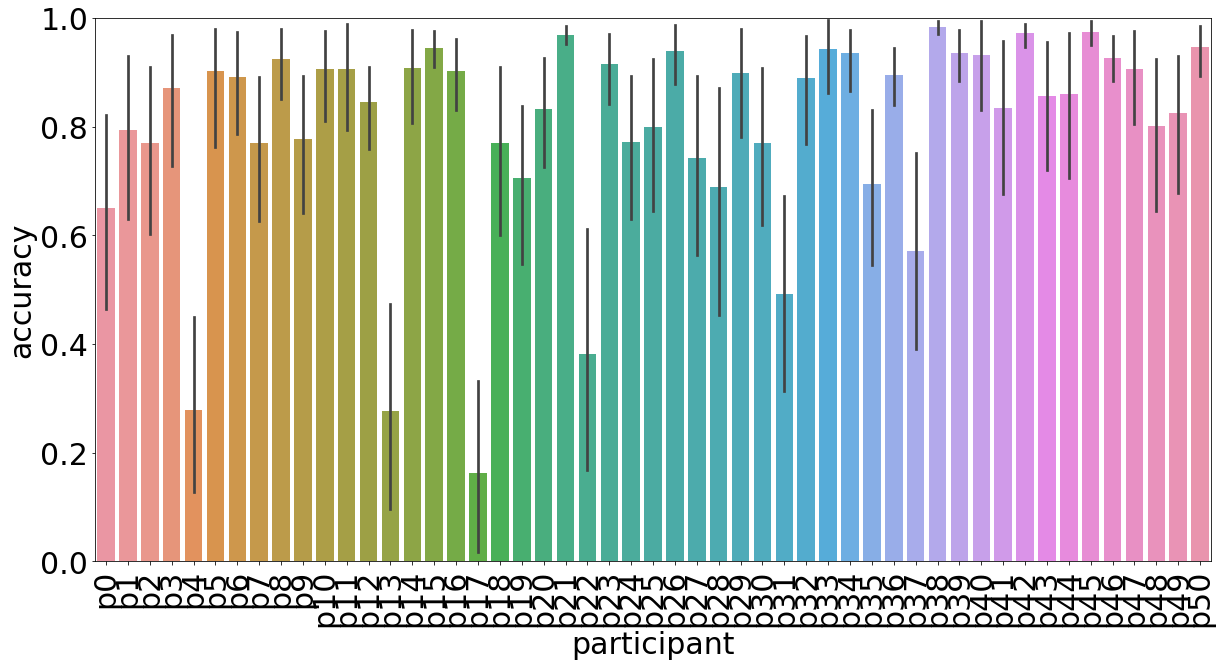

In [37]:
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.barplot(x='participant',y='accuracy',data=result)
plt.ylim([0,1])
plt.xticks(rotation=90)
plt.savefig('./images/partcipant_wise_performance_wisdm.png')
plt.show()

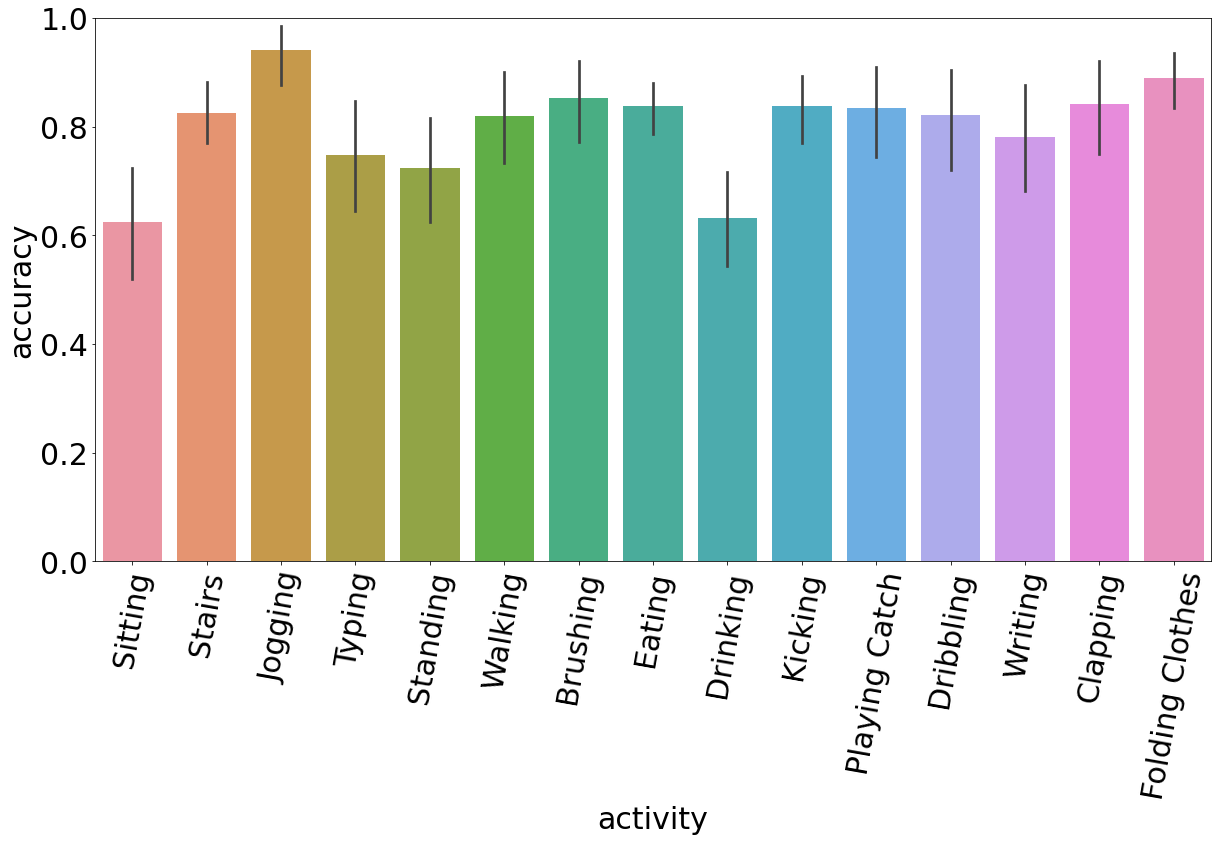

In [39]:
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.barplot(x='activity',y='accuracy',data=result)
plt.ylim([0,1])
plt.xticks(rotation=80)
plt.savefig('./images/activity_wise_performance_wisdm.png')
plt.show()

In [41]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(30,20))
sns.heatmap(confusion_matrix(data['original'],data['prediction'],normalize='true'),annot=True,fmt='.2f',cmap='Reds')
plt.xticks(np.array(range(15))+.5,activity_list,rotation=60)
plt.yticks(np.array(range(15))+.5,activity_list,rotation=0)
plt.savefig('confusion_matrix.pdf')
plt.show()